# Spherical orbit geodesics of photons around Kerr black hole

In [1]:
import curvedpy as cp
from curvedpy.utils.conversions import Conversions
conv = Conversions()

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

from curvedpy.geodesics.blackhole_integrators.kerr_SPH import GeodesicIntegratorKerr

print(cp.__version__)

0.0.4a2


$$
g_{\sigma \rho} = 
\begin{bmatrix}
- \frac{\Delta - a^2 \sin^2\theta}{\rho^2} & 0 & 0 & \frac{2Mra\sin^2\theta}{\rho^2}\\
0 & \frac{\rho^2}{\Delta} & 0 & 0\\
0 & 0 & \rho^2 & 0\\
\frac{2Mra\sin^2\theta}{\rho^2} & 0 & 0 & \frac{(r^2+a^2)^2-a^2\Delta\sin^2\theta}{\rho^2} \sin^2\theta
\end{bmatrix}
$$

$$
\Delta = r^2 - 2Mr +a^2
$$
$$
\rho^2 = r^2 +a^2\cos^2\theta
$$

The horizon ($g_{rr} \Rightarrow \inf$, $\Delta=0$) of a Kerr BH is given in BL coordinates like this:
$$
r_+ = M + \sqrt{M^2 - a^2}
$$
Where the ergoregion ($g_{tt} = 0$) is given by:
$$
r_0 = M + \sqrt{M^2-a^2\cos^2\theta}
$$


Photons have two (instable) circular and equatorial orbits. The first $r_1$ is prograde (with the rotation of the BH), the other $r_2$ is retrograde (against the rotation of the BH)::
$$
r_1 = 2M\left[ 1 + \cos \left( \frac{2}{3} \arccos \left( - a/M \right) \right) \right]
$$
$$
r_2 = 2M\left[ 1 + \cos \left( \frac{2}{3} \arccos \left( a/M \right) \right) \right]
$$
(See [Bardeen et al 1972](https://articles.adsabs.harvard.edu/pdf/1972ApJ...178..347B))
The photon orbits oscillate between the polar angles:
$$
\theta_{\pm} = \arccos(\mp \sqrt{u_+})
$$

$$
u_{\pm} = \frac{r}{a^2(r-M)^2} \left[-r^3 + 3M^2 r - 2 a^2 M \pm 2 \sqrt{M \Delta (2 r^3 - 3 M r^2 + a^2 M)} \right]
$$

## Lets program out these equations

In [2]:
def Delta(r, M, a): return r**2 - 2*M*r + a**2

In [3]:
# Horizon
def r_plus(M, a): return M + np.sqrt(M**2-a**2)
#
def r_ergo(M, a, theta): return M+np.sqrt(M**2-a**2 * np.cos(theta)**2)
# Prograde orbit:
def r1(M, a): return 2*M*(1+np.cos(2/3 * np.acos(-a/M)))
# Retrograde orbit
def r2(M, a): return 2*M*(1+np.cos(2/3 * np.acos(a/M)))
# No angular momentum orbit
def r3(M, a): 
    return M + 2*np.sqrt( M**2 - 1/3 *a**2 )  *\
    np.cos( 1/3 * np.arccos( M*(M**2-a**2)/(M**2 - 1/3*a**2)**(3/2) ) )

In [4]:
M, a = 1, 0.99
r_plus(M, a), r_ergo(M, a, 1/2*np.pi), r_ergo(M, a, 1/4*np.pi), r1(M, a), r2(M, a), r3(M, a)

(np.float64(1.141067359796659),
 np.float64(2.0),
 np.float64(1.7141078349941274),
 np.float64(1.1676418518575313),
 np.float64(3.991102861089397),
 np.float64(2.430983243806035))

In [5]:
def u_plus(r, a, M): 
    return r/(a**2 * (r-M)**2) * \
        ( -r**3 + 3*M**2*r -2*a**2*M \
         + 2 * np.sqrt(M*Delta(r, M, a)*(2*r**3 - 3*M*r**2 + a**2*M)) )
def u_min(r, a, M): 
    return r/(a**2 * (r-M)**2) * \
        ( -r**3 + 3*M**2*r -2*a**2*M \
         - 2 * np.sqrt(M*Delta(r, M, a)*(2*r**3 - 3*M*r**2 + a**2*M)) )

In [6]:
#def theta_plus(r, a, M): return np.arccos(-np.sqrt(round(u_plus(r, a, M),13)))
#def theta_min(r, a, M): return np.arccos(+np.sqrt(round(u_plus(r, a, M),13)))
def theta_plus(r, a, M): return np.arccos(-np.sqrt(u_plus(r, a, M)))
def theta_min(r, a, M): return np.arccos(+np.sqrt(u_plus(r, a, M)))

We also need a function to plot a sphere

In [41]:
def plot_sphere(r):
    theta = np.linspace(0, 2 * np.pi, 100)
    phi = np.linspace(0, np.pi, 50)
    theta, phi = np.meshgrid(theta, phi)
    
    # Convert to Cartesian coordinates
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return x, y, z

def plot_ring(r_BL, a):
    ph = np.array([i/100 * 2*np.pi for i in range(101)])
    th = np.array([1/2*np.pi for i in range(101)])
    r = np.array([r_BL for i  in range(101)])
    return conv.coord_conversion_bl_xyz(r, th, ph, a)

def plot_2sph(r_BL, a):
    x, y, z = conv.coord_conversion_bl_xyz(r_BL, 1/2*np.pi, 1/2*np.pi, a)
    r_XYZ = np.sqrt(x**2 + y**2 + z**2)
    
    theta = 1/2*np.pi#np.linspace(0, 0, 50)
    phi = np.linspace(0, 2*np.pi, 100)
    r = np.linspace(0, r_XYZ, 100)
    phi, r = np.meshgrid(phi, r)

    return conv.coord_conversion_sph_to_xyz(r, theta, phi)

def plot_ergo_XYZ(M = 1, a = 0.9):
    phi = np.linspace(0, 2 * np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    theta, phi = np.meshgrid(theta, phi)

    
    r0 = r_ergo(M, a, theta)
    # Convert to Cartesian coordinates
    x = np.sqrt(r0**2 + a**2) * np.sin(theta) * np.cos(phi)
    y = np.sqrt(r0**2 + a**2) * np.sin(theta) * np.sin(phi)
    z = r0 * np.cos(theta)
    return x, y, z

def plot_shell(M=1, a=0.9, flipPhi=1):
    r = np.linspace(r1(M, a), r2(M, a), 400)
    theta_down = np.array([theta_plus(i, a, M) for i in r])
    theta_up = np.array([theta_min(i, a, M) for i in r])
    
    phi = flipPhi*1/2*np.pi
    theta = np.concatenate([theta_down, np.flip(theta_up)])
    r = np.concatenate([r, np.flip(r)])
    x = np.sqrt(r**2 + a**2) * np.sin(theta) * np.cos(phi)
    y = np.sqrt(r**2 + a**2) * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z
    
def plot_hor_XYZ(M = 1, a = 0.9):
    r_BL = r_plus(M, a)
    
    phi = np.linspace(0, 2 * np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    theta, phi = np.meshgrid(theta, phi)

    x = np.sqrt(r_BL**2 + a**2) * np.sin(theta) * np.cos(phi)
    y = np.sqrt(r_BL**2 + a**2) * np.sin(theta) * np.sin(phi)
    z = r_BL * np.cos(theta)

    return x, y, z

(100, 100)


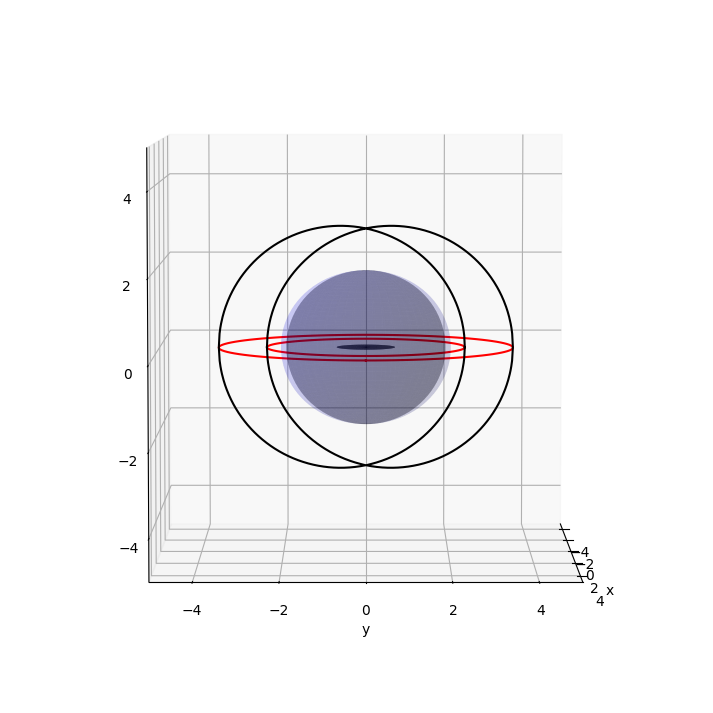

In [42]:

def plotty(M = 1, a= 0.5):
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.view_init(elev=5, azim=0)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #plt.axis('off')
    
    
    #ax.plot_surface(*plot_sphere(r_plus(1,0.9)), color="k", alpha=1.0)#cmap='viridis', 
    ax.plot_surface(*plot_hor_XYZ(M, a), color="k", alpha=0.2)#cmap='viridis', 
    
    ax.plot_surface(*plot_ergo_XYZ(M, a), color="b", alpha=0.1)#cmap='viridis', 
    
    # ph = np.array([i/100 * 2*np.pi for i in range(101)])
    # th = np.array([1/2*np.pi for i in range(101)])
    # r = np.array([r1(M, a) for i  in range(101)])
    # plt.plot(*conv.coord_conversion_bl_xyz(r, th, ph, a), "-" )
    plt.plot(*plot_ring(r1(M,a), a), "r-")
    plt.plot(*plot_ring(r2(M,a), a), "r-")

    # x, y, z = plot_ring(a, a)
    # print(len(z), len(x), len(y))
    x, y, z = plot_2sph(a, a)
    print(x.shape)
    
    ax.plot_surface(*plot_2sph(a, a), color="k", alpha=1)
    # ax.plot(*(np.column_stack(x3)[0]), "bo")
    # ax.plot(*x3, color="b")#, "o")
    
    plt.plot(*plot_shell(M, a), color="k", alpha=1)
    plt.plot(*plot_shell(M, a, flipPhi=-1), color="k", alpha=1)
    
    
    
    lim=5#r2(M, a) + 0.05*r2(M, a)
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_zlim(-lim,lim)
    plt.show()
plotty(1, 0.5)

## The inner, zero angular momentum and the outer orbits are

## The following function calculates the photon orbits

In [44]:

def plot_photon_orbit_f(r=3, a=0.5, step=0.01, curve_end = 100):
    M = 1

    if r >= r1(M, a) or r <= r2(M, a):
        
        # We calculate the minimal theta. 
        # Here the geodesic turns, so k_theta=0 and k_phi is some value.
        # This gives us the initial conditions
        th = theta_min(r, a, M)
        ph = 1/2*np.pi
        x3_0 = conv.coord_conversion_bl_xyz(r, th, ph, a)

        if r < r3(M, a):
            k3_0 = [-1,0,0]
        elif r > r3(M, a):
            k3_0 = [1,0,0]
        else:
            
            k3_0 = [0,0,-1]

        print(f"Stats: ")
        print(f" x0: {np.round(x3_0,1)}")
        print(f" k0: {k3_0}")
        
        bi = GeodesicIntegratorKerr(mass=M, a=a)
        k3, x3, _3 = bi.calc_trajectory(k3_0, x3_0, max_step=step, nr_points_curve=2000, curve_end=curve_end)
        #print(_3)
        # bi = cp.BlackholeGeodesicIntegrator(mass=M, a=a)
        # k3, x3, _3 = bi.geodesic(k3_0, x3_0, max_step=step3, nr_points_curve=2000, curve_end=300)
        
        r, th, ph = conv.coord_conversion_xyz_bl(*x3, a)

        print(f" - hit BH: {_3.hit_blackhole}")
        print(f" - r_mean = {round(np.mean(r),3)}, std(r) = {round(np.std(r),3)}")
        
        fig = plt.figure(figsize=(9,9))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_aspect('equal')
        ax.view_init(elev=5, azim=0)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        plt.axis('off')
        
        #ax.plot_surface(*plot_sphere(r_plus(M,a)), color="k", alpha=0.1)#cmap='viridis', 
    
        ax.plot_surface(*plot_hor_XYZ(M, a), color="k", alpha=0.2)#cmap='viridis', 
        ax.plot_surface(*plot_ergo_XYZ(M, a), color="b", alpha=0.1)#cmap='viridis', 
        plt.plot(*plot_ring(r1(M,a), a), "r-")
        plt.plot(*plot_ring(r2(M,a), a), "r-")
        ax.plot_surface(*plot_2sph(a, a), color="k", alpha=1)
    
        
        
        ax.plot(*(np.column_stack(x3)[0]), "bo")
        ax.plot(*x3, color="b")#, "o")
        
        lim=r2(M, a) + 0.05*r2(M, a)
        ax.set_xlim(-lim,lim)
        ax.set_ylim(-lim,lim)
        ax.set_zlim(-lim,lim)
        plt.show()

        return _3


In [70]:
# def plot_photon_orbit(r=3, a=0.5, step=0.01, curve_end = 100):
#     M = 1

#     if r >= r1(M, a) or r <= r2(M, a):
        
#         # We calculate the minimal theta. 
#         # Here the geodesic turns, so k_theta=0 and k_phi is some value.
#         # This gives us the initial conditions
#         th = theta_min(r, a, M)
#         ph = 1/2*np.pi
#         x3_0 = conv.coord_conversion_bl_xyz(r, th, ph, a)

#         if r < r3(M, a):
#             k3_0 = [-1,0,0]
#         elif r > r3(M, a):
#             k3_0 = [1,0,0]
#         else:
            
#             k3_0 = [0,0,-1]

#         print(f"Stats: ")
#         print(f" x0: {np.round(x3_0,1)}")
#         print(f" k0: {k3_0}")
        
#         bi = GeodesicIntegratorKerr(mass=M, a=a)
#         k3, x3, _3 = bi.calc_trajectory(k3_0, x3_0, max_step=step, nr_points_curve=2000, curve_end=curve_end)
#         #print(_3)
#         # bi = cp.BlackholeGeodesicIntegrator(mass=M, a=a)
#         # k3, x3, _3 = bi.geodesic(k3_0, x3_0, max_step=step3, nr_points_curve=2000, curve_end=300)
        
#         r, th, ph = conv.coord_conversion_xyz_bl(*x3, a)

#         print(f" - hit BH: {_3.hit_blackhole}")
#         print(f" - r_mean = {round(np.mean(r),3)}, std(r) = {round(np.std(r),3)}")
        
#         fig = plt.figure(figsize=(9,9))
#         ax = fig.add_subplot(111, projection='3d')
#         ax.set_aspect('equal')
#         ax.view_init(elev=40, azim=45)
#         ax.set_xlabel("x")
#         ax.set_ylabel("y")
#         plt.axis('off')
        
#         #ax.plot_surface(*plot_sphere(r_plus(M,a)), color="k", alpha=0.1)#cmap='viridis', 
#         ax.plot_surface(*plot_hor_XYZ(M,a), color="k", alpha=0.1)#cmap='viridis', 
#         ax.plot_surface(*plot_sphere(np.linalg.norm(x3_0)), color="b", alpha=0.1)#cmap='viridis', 
#         ax.plot(*(np.column_stack(x3)[0]), "bo")
#         ax.plot(*x3, color="b")#, "o")
        
#         lim=r2(M, a) + 0.05*r2(M, a)
#         ax.set_xlim(-lim,lim)
#         ax.set_ylim(-lim,lim)
#         ax.set_zlim(-lim,lim)
#         plt.show()

#         return _3


## Here are some examples

The inner, prograde, equatorial photon orbit at r1:

1.8660254037844386 2.34729635533386
Stats: 
 x0: [0.  2.4 0. ]
 k0: [-1, 0, 0]
 - hit BH: False
 - r_mean = 2.347, std(r) = 0.0


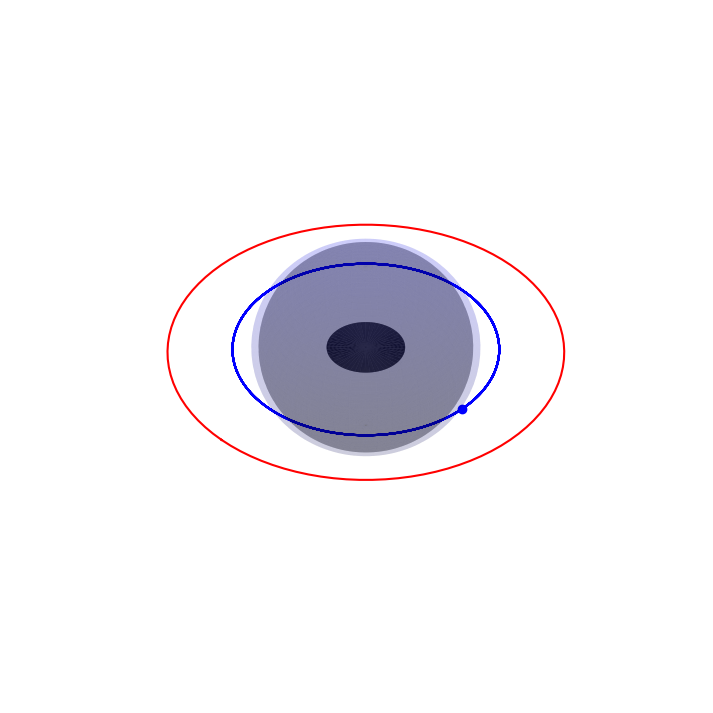

           message: The solver successfully reached the end of the integration interval.
           success: True
            status: 0
                 t: [ 0.000e+00  5.003e-02 ...  9.995e+01  1.000e+02]
                 y: [[-6.261e-17 -3.900e-17 ... -3.535e-15 -3.508e-15]
                     [ 2.347e+00  2.347e+00 ...  2.347e+00  2.347e+00]
                     ...
                     [ 1.571e+00  1.592e+00 ...  4.322e+01  4.324e+01]
                     [ 1.707e+00  1.707e+00 ...  1.707e+00  1.707e+00]]
               sol: None
          t_events: [array([], dtype=float64), array([], dtype=float64)]
          y_events: [array([], dtype=float64), array([], dtype=float64)]
              nfev: 60002
              njev: 0
               nlu: 0
             R_end: inf
     hit_blackhole: False
 start_inside_hole: False
         end_check: False
            k4_xyz: [[ 1.707e+00  1.707e+00 ...  1.707e+00  1.707e+00]
                     [-1.000e+00 -9.998e-01 ...  6.925e-01  6.773e-01]

In [164]:
M, a = 1, 0.5
print(r_plus(M, a), r1(M, a))
plot_photon_orbit_f(r=r1(M, a), a=a, step=0.01, curve_end=100)

The outer, retrograde, equatorial photon orbit at r2:

Stats: 
 x0: [0.  3.6 0. ]
 k0: [1, 0, 0]
 - hit BH: False
 - r_mean = 3.532, std(r) = 0.0


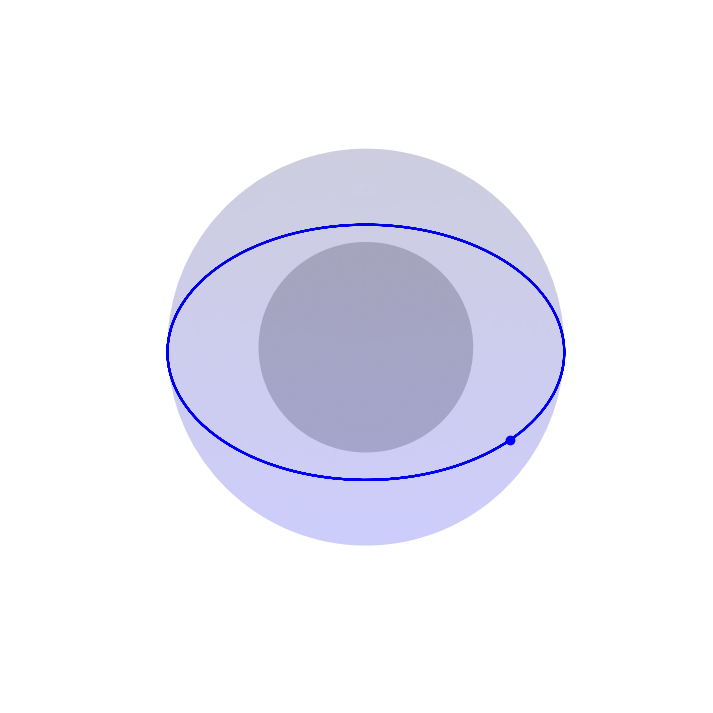

           message: The solver successfully reached the end of the integration interval.
           success: True
            status: 0
                 t: [ 0.000e+00  5.003e-02 ...  9.995e+01  1.000e+02]
                 y: [[ 6.184e-17  6.184e-17 ...  6.184e-17  6.184e-17]
                     [ 3.532e+00  3.532e+00 ...  3.532e+00  3.532e+00]
                     ...
                     [ 1.571e+00  1.557e+00 ... -2.645e+01 -2.646e+01]
                     [ 1.721e+00  1.721e+00 ...  1.721e+00  1.721e+00]]
               sol: None
          t_events: [array([], dtype=float64), array([], dtype=float64)]
          y_events: [array([], dtype=float64), array([], dtype=float64)]
              nfev: 60002
              njev: 0
               nlu: 0
             R_end: inf
     hit_blackhole: False
 start_inside_hole: False
         end_check: False
            k4_xyz: [[ 1.721e+00  1.721e+00 ...  1.721e+00  1.721e+00]
                     [ 1.000e+00  9.999e-01 ... -9.674e-01 -9.709e-01]

In [12]:
plot_photon_orbit_f(r=r2(1,0.5), a=0.5, step=0.01, curve_end=100)

Another prograde photon orbit:

2.5472963553338603
Stats: 
 x0: [0.  1.5 2.1]
 k0: [-1, 0, 0]
 - hit BH: False
 - r_mean = 2.547, std(r) = 0.0


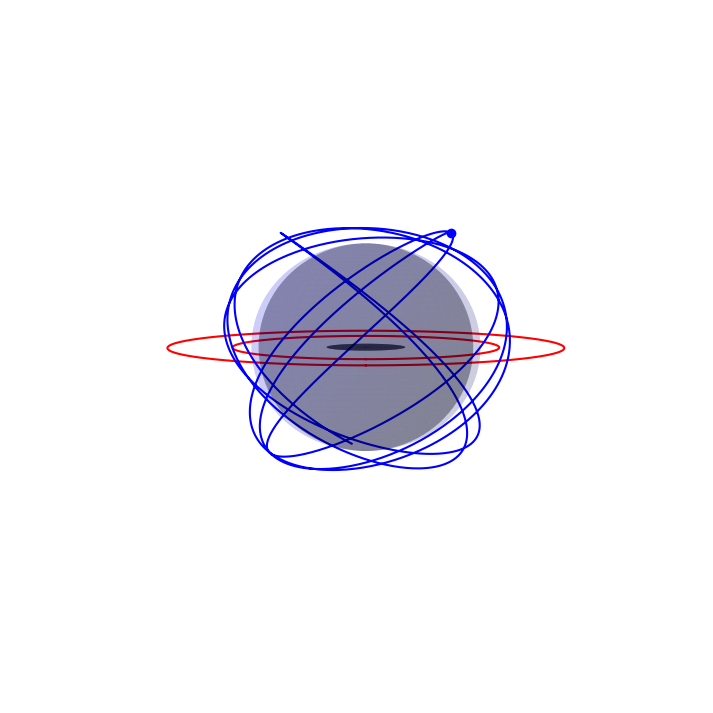

           message: The solver successfully reached the end of the integration interval.
           success: True
            status: 0
                 t: [ 0.000e+00  5.003e-02 ...  9.995e+01  1.000e+02]
                 y: [[-3.573e-17 -8.239e-17 ...  2.972e-07  3.019e-07]
                     [ 2.547e+00  2.547e+00 ...  2.547e+00  2.547e+00]
                     ...
                     [ 1.571e+00  1.604e+00 ...  4.384e+01  4.386e+01]
                     [ 1.739e+00  1.739e+00 ...  1.754e+00  1.754e+00]]
               sol: None
          t_events: [array([], dtype=float64), array([], dtype=float64)]
          y_events: [array([], dtype=float64), array([], dtype=float64)]
              nfev: 60002
              njev: 0
               nlu: 0
             R_end: inf
     hit_blackhole: False
 start_inside_hole: False
         end_check: False
            k4_xyz: [[ 1.739e+00  1.739e+00 ...  1.754e+00  1.754e+00]
                     [-1.000e+00 -9.998e-01 ... -2.370e-01 -2.555e-01]

In [172]:
print(r1(1,0.5)+0.2)
plot_photon_orbit_f(r=r1(1,0.5)+0.2, a=0.5, step=0.01, curve_end=100)

Another retrograde photon orbit:

3.332088886237956
Stats: 
 x0: [0.  2.4 2.4]
 k0: [1, 0, 0]
 - hit BH: False
 - r_mean = 3.332, std(r) = 0.0


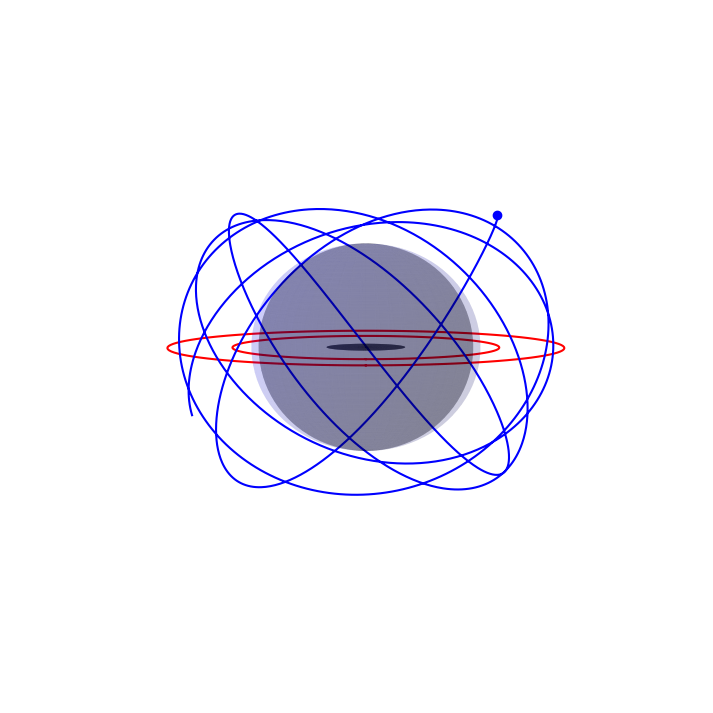

           message: The solver successfully reached the end of the integration interval.
           success: True
            status: 0
                 t: [ 0.000e+00  5.003e-02 ...  9.995e+01  1.000e+02]
                 y: [[ 4.290e-17  4.134e-17 ... -2.578e-15 -2.563e-15]
                     [ 3.332e+00  3.332e+00 ...  3.332e+00  3.332e+00]
                     ...
                     [ 1.571e+00  1.550e+00 ... -2.653e+01 -2.654e+01]
                     [ 1.732e+00  1.732e+00 ...  1.742e+00  1.742e+00]]
               sol: None
          t_events: [array([], dtype=float64), array([], dtype=float64)]
          y_events: [array([], dtype=float64), array([], dtype=float64)]
              nfev: 60002
              njev: 0
               nlu: 0
             R_end: inf
     hit_blackhole: False
 start_inside_hole: False
         end_check: False
            k4_xyz: [[ 1.732e+00  1.732e+00 ...  1.742e+00  1.742e+00]
                     [ 1.000e+00  9.999e-01 ... -7.122e-01 -7.158e-01]

In [174]:
print(r2(1,0.5)-0.2)
plot_photon_orbit_f(r=r2(1,0.5)-0.2, a=0.5, step=0.01, curve_end=100)

In [47]:
print(r1(1,0.5)+0.1)

2.4472963553338603


$dt d\phi$

3.332088886237956
Stats: 
 x0: [0.  2.  1.5]
 k0: [-1, 0, 0]
 - hit BH: False
 - r_mean = 2.447, std(r) = 0.0


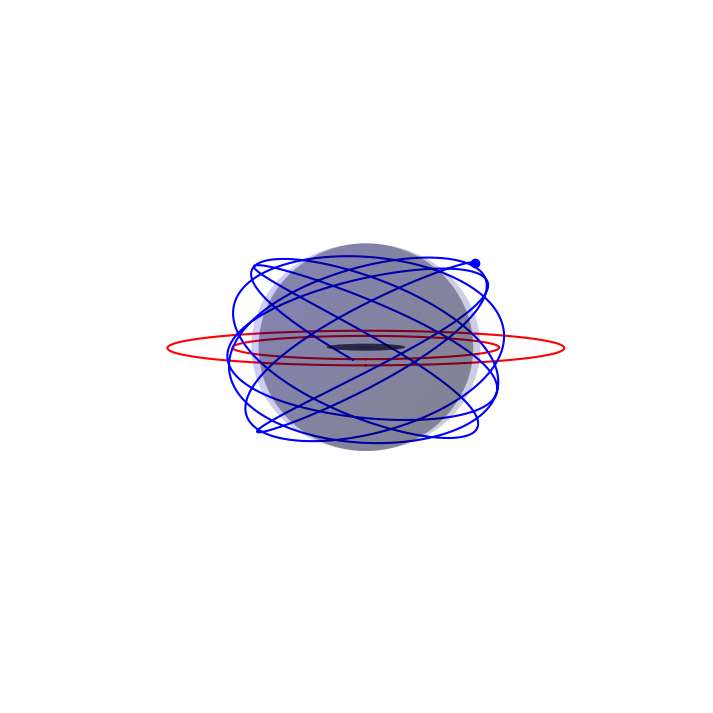

           message: The solver successfully reached the end of the integration interval.
           success: True
            status: 0
                 t: [ 0.000e+00  5.003e-02 ...  9.995e+01  1.000e+02]
                 y: [[-4.824e-17 -3.457e-17 ...  1.568e-14  1.567e-14]
                     [ 2.447e+00  2.447e+00 ...  2.447e+00  2.447e+00]
                     ...
                     [ 1.571e+00  1.596e+00 ...  4.388e+01  4.389e+01]
                     [ 1.727e+00  1.727e+00 ...  1.747e+00  1.747e+00]]
               sol: None
          t_events: [array([], dtype=float64), array([], dtype=float64)]
          y_events: [array([], dtype=float64), array([], dtype=float64)]
              nfev: 60002
              njev: 0
               nlu: 0
             R_end: inf
     hit_blackhole: False
 start_inside_hole: False
         end_check: False
            k4_xyz: [[ 1.727e+00  1.727e+00 ...  1.747e+00  1.747e+00]
                     [-1.000e+00 -9.998e-01 ...  9.846e-02  7.754e-02]

In [45]:

plot_photon_orbit_f(r=r1(1,0.5)+0.1, a=0.5, step=0.01, curve_end=100)

2.35729635533386
Stats: 
 x0: [0.  2.4 0.5]
 k0: [-1, 0, 0]
 - hit BH: False
 - r_mean = 2.357, std(r) = 0.0


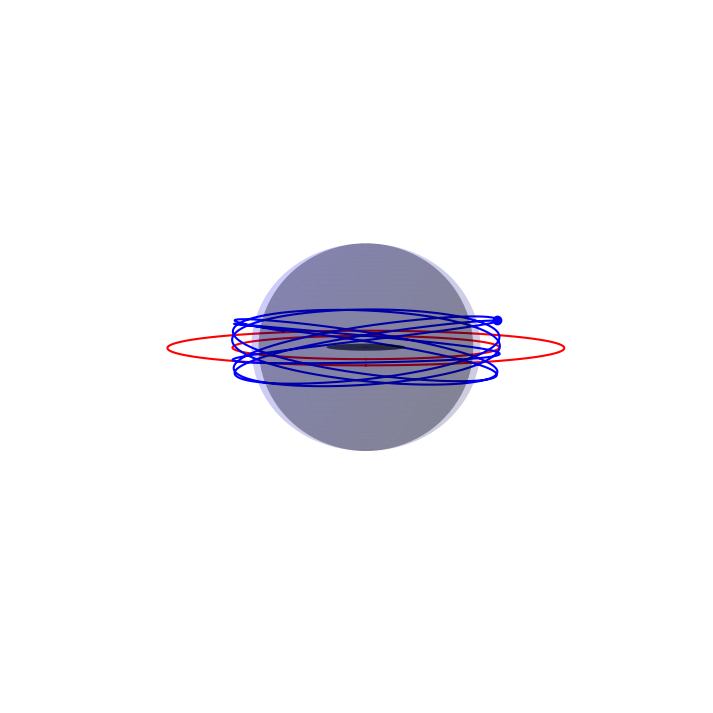

           message: The solver successfully reached the end of the integration interval.
           success: True
            status: 0
                 t: [ 0.000e+00  5.003e-02 ...  9.995e+01  1.000e+02]
                 y: [[-6.106e-17 -2.453e-17 ...  6.375e-04  6.478e-04]
                     [ 2.357e+00  2.357e+00 ...  2.359e+00  2.359e+00]
                     ...
                     [ 1.571e+00  1.592e+00 ...  4.331e+01  4.333e+01]
                     [ 1.709e+00  1.709e+00 ...  1.706e+00  1.705e+00]]
               sol: None
          t_events: [array([], dtype=float64), array([], dtype=float64)]
          y_events: [array([], dtype=float64), array([], dtype=float64)]
              nfev: 60002
              njev: 0
               nlu: 0
             R_end: inf
     hit_blackhole: False
 start_inside_hole: False
         end_check: False
            k4_xyz: [[ 1.709e+00  1.709e+00 ...  1.706e+00  1.705e+00]
                     [-1.000e+00 -9.998e-01 ...  6.293e-01  6.130e-01]

In [49]:
print( r1(1,0.5)+0.01 )
plot_photon_orbit_f(r=r1(1,0.5)+0.01, a=0.5, step=0.01, curve_end=100)

3.5220888862379565
Stats: 
 x0: [0.  3.5 0.6]
 k0: [1, 0, 0]
 - hit BH: False
 - r_mean = 3.522, std(r) = 0.0


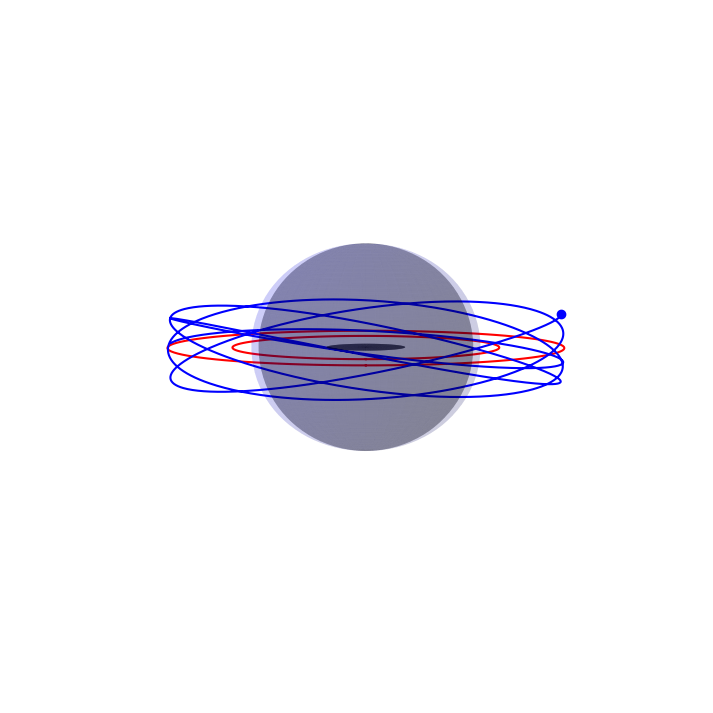

           message: The solver successfully reached the end of the integration interval.
           success: True
            status: 0
                 t: [ 0.000e+00  5.003e-02 ...  9.995e+01  1.000e+02]
                 y: [[ 6.089e-17  6.412e-17 ... -1.381e-05 -1.404e-05]
                     [ 3.522e+00  3.522e+00 ...  3.522e+00  3.522e+00]
                     ...
                     [ 1.571e+00  1.557e+00 ... -2.647e+01 -2.648e+01]
                     [ 1.721e+00  1.721e+00 ...  1.722e+00  1.722e+00]]
               sol: None
          t_events: [array([], dtype=float64), array([], dtype=float64)]
          y_events: [array([], dtype=float64), array([], dtype=float64)]
              nfev: 60002
              njev: 0
               nlu: 0
             R_end: inf
     hit_blackhole: False
 start_inside_hole: False
         end_check: False
            k4_xyz: [[ 1.721e+00  1.721e+00 ...  1.722e+00  1.722e+00]
                     [ 1.000e+00  9.999e-01 ... -9.524e-01 -9.555e-01]

In [50]:
print( r2(1,0.5)-0.01 )
plot_photon_orbit_f(r=r2(1,0.5)-0.01, a=0.5, step=0.01, curve_end=100)

Stats: 
 - hit BH: True
 - r_mean = 3.051, std(r) = 0.149


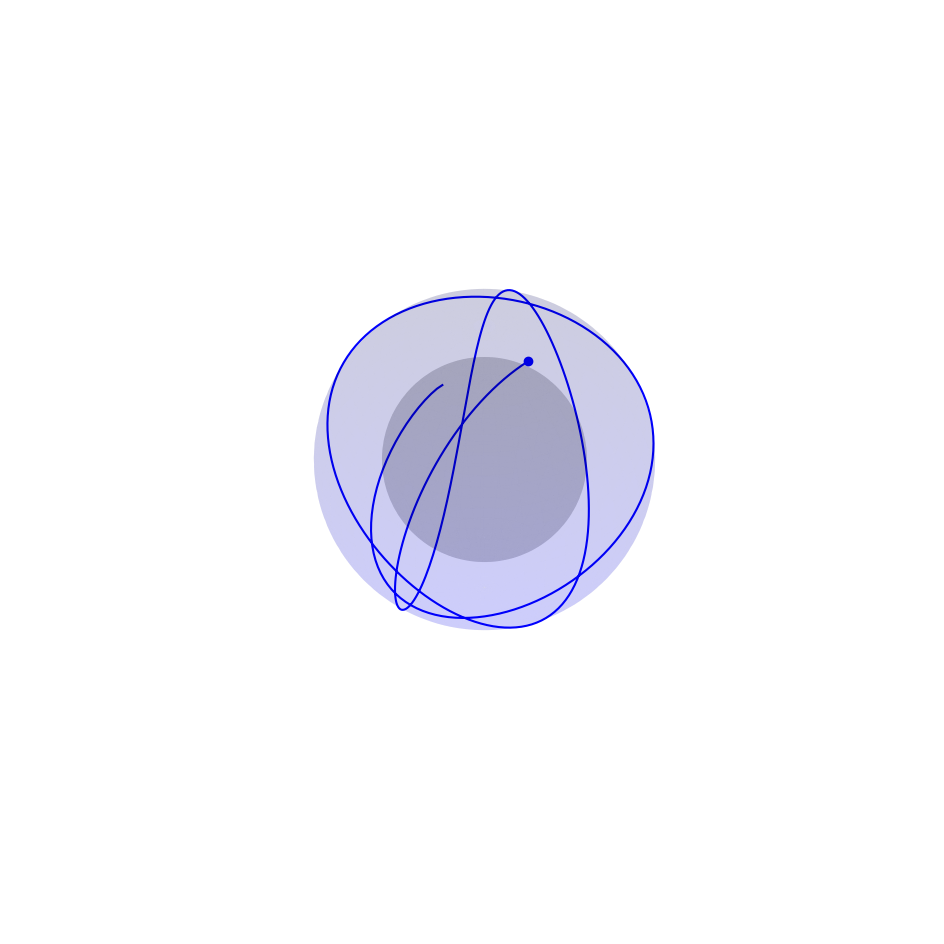

In [55]:
plot_photon_orbit(r=3.1)

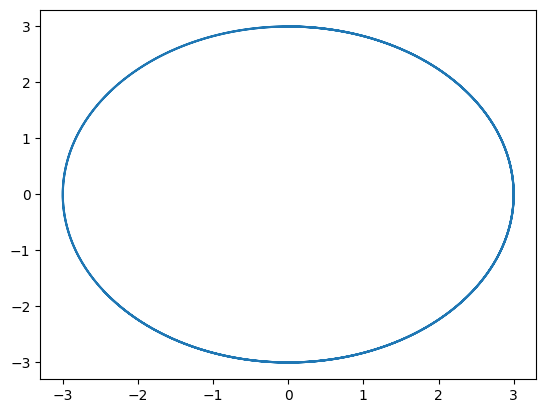

In [4]:
def plot_a0():
    bi = cp.BlackholeGeodesicIntegrator(mass=1, a=0)
    
    k0 = [1,0,0]
    x0 = [0,3,0]
    k, x, _ = bi.geodesic(k0, x0, max_step=0.01, nr_points_curve=1000, curve_end=50)
    plt.plot(x[0],x[1])
    plt.show()

plot_a0()


2.3472963556282425 2.34729635533386
7.75705808299087e-10
3.5320888862075943 3.5320888862379562
8.133247873392952e-11
Shape of x, y, z: (50, 100)
Shape of x, y, z: (50, 100)
Shape of x, y, z: (50, 100)


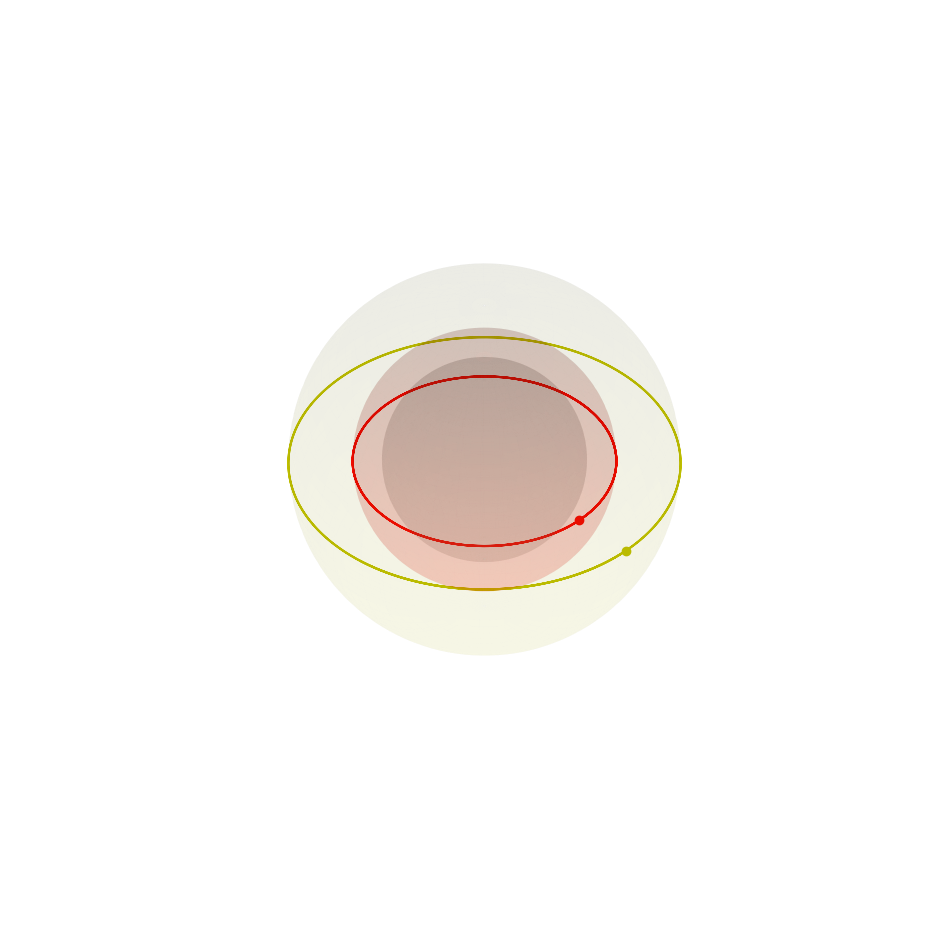

In [9]:
def plot_a05(step=0.01):
    # def to_cart(r, th, ph, a):
    # x = np.sqrt(r**2 + a**2) * np.sin(th) * np.cos(ph)
    # y = np.sqrt(r**2 + a**2) * np.sin(th) * np.sin(ph)
    # z = r * np.cos(th)
    # return x, y, z
    
    M = 1
    a = 0.5
    
    bi = cp.BlackholeGeodesicIntegrator(mass=M, a=a)
    
    x1_0 = conv.coord_conversion_bl_xyz(r1(M,a), 1/2*np.pi, 1/2*np.pi, a)
    k1_0 = [-1,0,0]
    k1, x1, _1 = bi.geodesic(k1_0, x1_0, max_step=step, nr_points_curve=1000, curve_end=50)
    # plt.plot(x[0],x[1], "--")
    r, th, ph = conv.coord_conversion_xyz_bl(*x1, a)
    print(np.mean(r), r1(M,a))
    print(np.std(r))
    
    x2_0 = conv.coord_conversion_bl_xyz(r2(M,a), 1/2*np.pi, 1/2*np.pi, a)
    k2_0 = [1,0,0]
    k2, x2, _2 = bi.geodesic(k2_0, x2_0, max_step=step, nr_points_curve=1000, curve_end=50)
    #plt.plot(x[0],x[1], "--")
    r, th, ph = conv.coord_conversion_xyz_bl(*x2, a)
    print(np.mean(r), r2(M,a))
    print(np.std(r))
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.view_init(elev=40, azim=45)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.axis('off')
    #ax.set_facecolor("k")

    ax.plot_surface(*plot_sphere(r_plus(M,a)), color="gray", alpha=0.1)#cmap='viridis', 
    
    ax.plot(*x1, color="r")
    ax.plot(*(np.column_stack(x1)[0]), "ro")
    ax.plot_surface(*plot_sphere(np.linalg.norm(x1_0)), color="r", alpha=0.1)#cmap='viridis', 
    
    ax.plot(*x2, color="y")
    ax.plot(*(np.column_stack(x2)[0]), "yo")
    ax.plot_surface(*plot_sphere(np.linalg.norm(x2_0)), color="y", alpha=0.05)#cmap='viridis', 

    
    lim=5
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_zlim(-lim,lim)
    plt.show()
plot_a05(step=0.01)

2.999999999578268
1.1274743336884642e-09
Shape of x, y, z: (50, 100)
Shape of x, y, z: (50, 100)


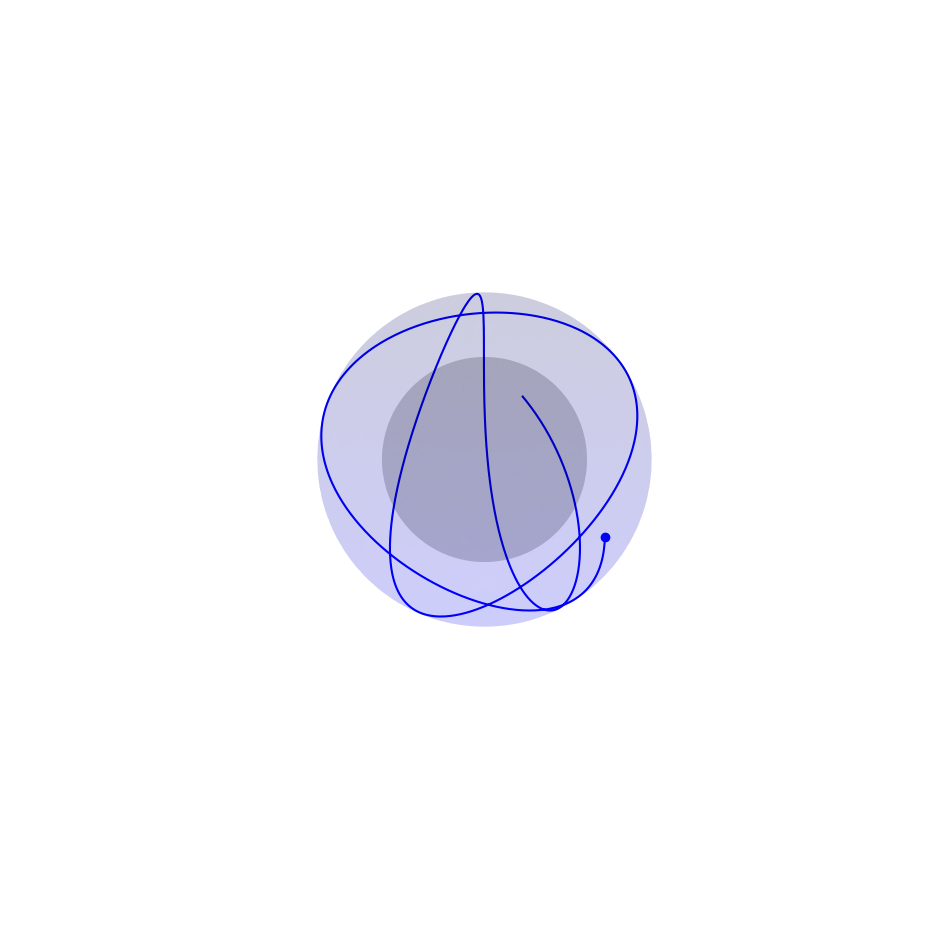

In [10]:
def plot_a05(step3=0.01):
    # def to_cart(r, th, ph, a):
    # x = np.sqrt(r**2 + a**2) * np.sin(th) * np.cos(ph)
    # y = np.sqrt(r**2 + a**2) * np.sin(th) * np.sin(ph)
    # z = r * np.cos(th)
    # return x, y, z
    
    M = 1
    a = 0.5
    
    bi = cp.BlackholeGeodesicIntegrator(mass=M, a=a)
    
    #x3_0 = conv.coord_conversion_bl_xyz(r3(M,a), 1/2*np.pi, 1/2*np.pi, a)
    x3_0 = conv.coord_conversion_bl_xyz(3, 1/2*np.pi, 1/2*np.pi, a)
    k3_0 = [0, 0, -0.1]
    k3, x3, _3 = bi.geodesic(k3_0, x3_0, max_step=step3, nr_points_curve=1000, curve_end=500)
    #_r3 = conv.coord_conversion_xyz_bl( *x3, a )
    #print(_r3)
    #plt.plot(x[0],x[1], "--")
    #print(_3)#.hit_blackhole)

    r, th, ph = conv.coord_conversion_xyz_bl(*x3, a)
    print(np.mean(r))
    print(np.std(r))
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.view_init(elev=40, azim=45)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.axis('off')
    #ax.set_facecolor("k")
    
    ax.plot_surface(*plot_sphere(r_plus(M,a)), color="k", alpha=0.1)#cmap='viridis', 
    ax.plot_surface(*plot_sphere(np.linalg.norm(x3_0)), color="b", alpha=0.1)#cmap='viridis', 
    ax.plot(*(np.column_stack(x3)[0]), "bo")
    ax.plot(*x3, color="b")#, "o")
    
    lim=5
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_zlim(-lim,lim)
    plt.show()
plot_a05(step3=0.01)

3.4 0.932279388664132 1.5707963267948966
(np.float64(1.6897047791717612e-16), np.float64(2.759497318489216), np.float64(2.0264177731841664))
           message: The solver successfully reached the end of the integration interval.
           success: True
            status: 0
                 t: [ 0.000e+00  1.501e-01 ...  2.998e+02  3.000e+02]
                 y: [[ 4.932e-17  5.654e-17 ...  1.055e-14  1.053e-14]
                     [ 3.400e+00  3.400e+00 ...  3.400e+00  3.400e+00]
                     ...
                     [ 1.571e+00  1.516e+00 ... -8.286e+01 -8.290e+01]
                     [ 1.729e+00  1.729e+00 ...  1.733e+00  1.733e+00]]
               sol: None
          t_events: [array([], dtype=float64), array([], dtype=float64)]
          y_events: [array([], dtype=float64), array([], dtype=float64)]
              nfev: 180008
              njev: 0
               nlu: 0
             R_end: inf
     hit_blackhole: False
 start_inside_hole: False
         end_check: False

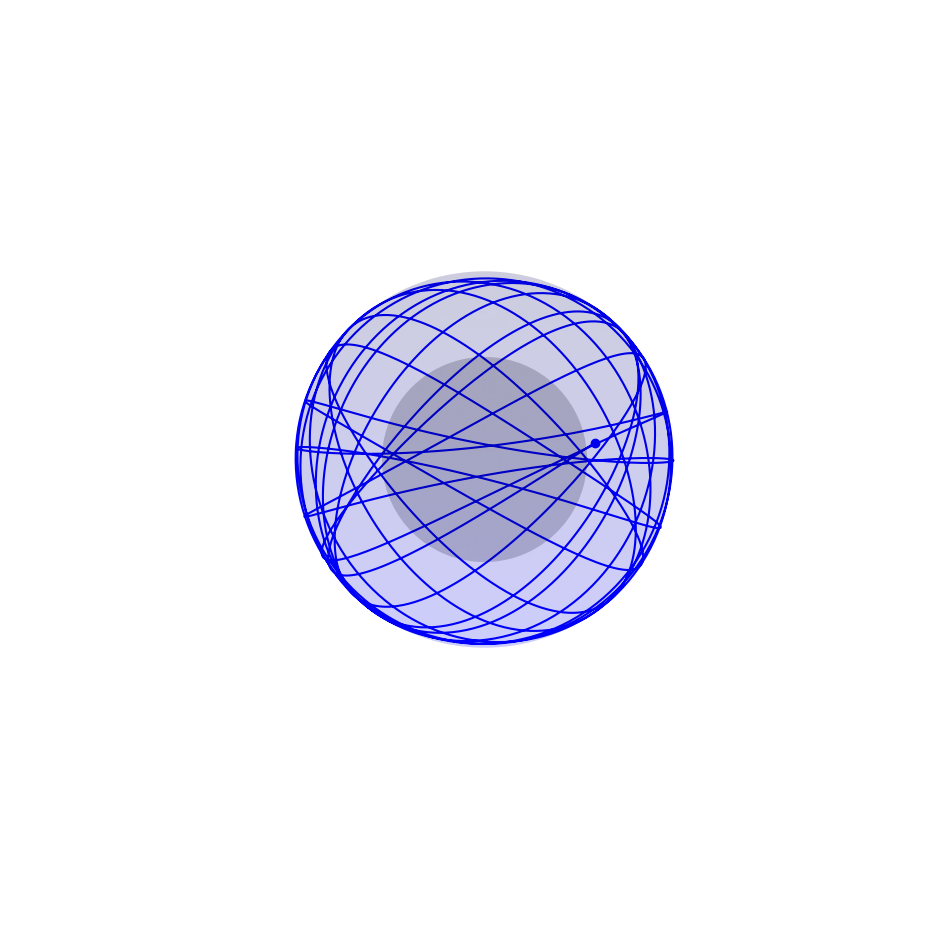

In [37]:
def plot_a05(step3=0.01):
    # def to_cart(r, th, ph, a):
    # x = np.sqrt(r**2 + a**2) * np.sin(th) * np.cos(ph)
    # y = np.sqrt(r**2 + a**2) * np.sin(th) * np.sin(ph)
    # z = r * np.cos(th)
    # return x, y, z
    
    M = 1
    a = 0.5

    r = 3.4*M
    th = theta_min(r, a, M)
    ph = 1/2*np.pi
    x3_0 = conv.coord_conversion_bl_xyz(r, th, ph, a)
    k3_0 = [1,0,0]
    print(r, th, ph)
    print(x3_0)

    bi = GeodesicIntegratorKerr(mass=M, a=a)
    k3, x3, _3 = bi.calc_trajectory(k3_0, x3_0, max_step=step3, nr_points_curve=2000, curve_end=300)

    # bi = cp.BlackholeGeodesicIntegrator(mass=M, a=a)
    # k3, x3, _3 = bi.geodesic(k3_0, x3_0, max_step=step3, nr_points_curve=2000, curve_end=300)
    
    print(_3)#.hit_blackhole)

    r, th, ph = conv.coord_conversion_xyz_bl(*x3, a)
    print(np.mean(r))
    print(np.std(r))
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.view_init(elev=40, azim=45)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.axis('off')
    #ax.set_facecolor("k")
    
    ax.plot_surface(*plot_sphere(r_plus(M,a)), color="k", alpha=0.1)#cmap='viridis', 
    ax.plot_surface(*plot_sphere(np.linalg.norm(x3_0)), color="b", alpha=0.1)#cmap='viridis', 
    ax.plot(*(np.column_stack(x3)[0]), "bo")
    ax.plot(*x3, color="b")#, "o")
    
    lim=5
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_zlim(-lim,lim)
    plt.show()
plot_a05(step3=0.01)